In [1]:
import qiskit
import numpy as np
import sys
sys.path.insert(1, '../')
import qtm.base, qtm.constant, qtm.nqubit, qtm.fubini_study, qtm.encoding
import importlib
importlib.reload(qtm.base)
importlib.reload(qtm.constant)
importlib.reload(qtm.onequbit)
importlib.reload(qtm.nqubit)
importlib.reload(qtm.fubini_study)

<module 'qtm.fubini_study' from '..\\qtm\\fubini_study.py'>

20/12/2021

In this notebook I will conduct the experiments about tomography.

With $U_{gen} = $ Haar random

And $U_{target} = W + ZXZ, W = W_{chain}, W_{all to all}, W_{alternating}$

### 1. W_{chain}

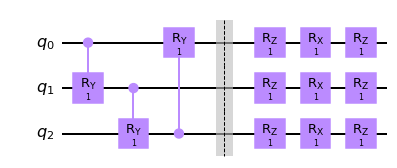

In [107]:
num_qubits = 3
num_layers = 1
thetas = np.ones(num_layers*num_qubits*4)
psi = 2*np.random.rand(2**num_qubits)-1
psi = psi / np.linalg.norm(psi)
encoder = qtm.encoding.Encoding(psi, 'amplitude_encoding')

qc = qiskit.QuantumCircuit(num_qubits)
qc = qtm.nqubit.create_Wchain_layerd_state(qc, thetas, num_layers=num_layers)
qc.draw('mpl')

In [3]:
num_qubits = 3
thetas = np.random.random(4)
qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
qc = qtm.nqubit.create_Wchain(qc, thetas)
print(qiskit.quantum_info.Statevector.from_instruction(qc))

Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2))


In [4]:
num_qubits = 4
num_layers = 2
thetas = np.ones(num_layers*num_qubits*4)
# for i in range(0, len(thetas)):
#     thetas[i] += i
psi = 2*np.random.rand(2**num_qubits)-1
psi = psi / np.linalg.norm(psi)
encoder = qtm.encoding.Encoding(psi, 'amplitude_encoding')
loss_values = []
thetass = []
for i in range(0, 300):
    if i % 10 == 0:
        print('W_chain: ', i)
    # qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    
    qc = encoder.qcircuit

    G = qtm.fubini_study.calculate_Wchain_state(qc.copy(), thetas, num_layers)
    grad_loss = qtm.base.grad_loss(
        qc, 
        qtm.nqubit.create_Wchainchecker_haar,
        thetas, r = 1/2, s = np.pi/2, num_layers = num_layers)
    
    thetas = np.real(thetas - qtm.constant.learning_rate*(np.linalg.pinv(G) @ grad_loss))
    thetass.append(thetas.copy())
    qc_copy = qtm.nqubit.create_Wchainchecker_haar(qc.copy(), thetas, num_layers)  
    loss = qtm.base.loss_basis(qtm.base.measure(qc_copy, list(range(qc_copy.num_qubits))))
    loss_values.append(loss)


W_chain:  0
W_chain:  10
W_chain:  20
W_chain:  30
W_chain:  40
W_chain:  50
W_chain:  60
W_chain:  70
W_chain:  80
W_chain:  90
W_chain:  100
W_chain:  110
W_chain:  120
W_chain:  130
W_chain:  140
W_chain:  150
W_chain:  160
W_chain:  170
W_chain:  180
W_chain:  190
W_chain:  200
W_chain:  210
W_chain:  220
W_chain:  230
W_chain:  240
W_chain:  250
W_chain:  260
W_chain:  270
W_chain:  280
W_chain:  290


In [20]:
traces = []
fidelities = []

for thetas in thetass:
    # Get |psi> = U_gen|000...>
    qc1 = encoder.qcircuit
    psi = qiskit.quantum_info.Statevector.from_instruction(qc1)
    # Get |psi~> = U_target|000...>
    qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    qc = qtm.nqubit.create_Wchain_layerd_state(qc, thetas, num_layers = num_layers).inverse()
    psi_hat = qiskit.quantum_info.Statevector.from_instruction(qc)
    # Calculate the metrics
    trace, fidelity = qtm.base.get_metrics(psi, psi_hat)
    traces.append(trace)
    fidelities.append(fidelity)
print('Writting ... ' + str(num_qubits))

np.savetxt("../../experiments/tomography_wchain_" + str(num_layers) + '/' + str(num_qubits) + "/loss_values_qng.csv", loss_values, delimiter=",")
np.savetxt("../../experiments/tomography_wchain_" + str(num_layers) + '/' + str(num_qubits) + "/thetass_qng.csv", thetass, delimiter=",")
np.savetxt("../../experiments/tomography_wchain_" + str(num_layers) + '/' + str(num_qubits) + "/traces_qng.csv", traces, delimiter=",")
np.savetxt("../../experiments/tomography_wchain_" + str(num_layers) + '/' + str(num_qubits) + "/fidelities_qng.csv", fidelities, delimiter=",")

Writting ... 4


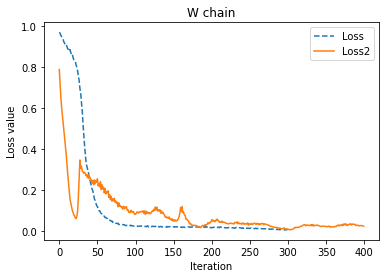

In [10]:
from matplotlib import pyplot as plt
import pandas as pd
# plt.plot(fidelities, label='Fidelity', linestyle = '-')
# plt.plot(traces, label='Trace', linestyle = '-.')
path = "../../experiments/tomography_wchain_4/4/loss_values_qng.csv"
loss_values1 = pd.read_csv(path, sep=",", header=None)
plt.plot(loss_values, label='Loss', linestyle = '--')
plt.plot(loss_values1, label='Loss2')
plt.title('W chain')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss value")
plt.show() 

In [39]:
for i in range(0, 100):
    if i % 2 == 0:
        print('W_chain: ', i)
    # qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    
    qc = encoder.qcircuit

    G = qtm.fubini_study.calculate_Wchain_state(qc.copy(), thetas, num_layers)
    grad_loss = qtm.base.grad_loss(
        qc, 
        qtm.nqubit.create_Wchainchecker_haar,
        thetas, r = 1/2, s = np.pi/2, num_layers = num_layers)
    
    thetas = np.real(thetas - qtm.constant.learning_rate*(np.linalg.pinv(G) @ grad_loss))
    thetass.append(thetas.copy())
    qc_copy = qtm.nqubit.create_Wchainchecker_haar(qc.copy(), thetas, num_layers)  
    loss = qtm.base.loss_basis(qtm.base.measure(qc_copy, list(range(qc_copy.num_qubits))))
    loss_values.append(loss)

W_chain:  0
[-0.2013845   0.86222885  1.12176     1.16562961  0.59551896  0.98803294
  1.85243229  0.65976129 -0.35305732  0.3348208   1.83459368  1.32587023]
[ 1.93801356 -0.9205878   1.06041949  0.08440763  1.19711121  1.296036
  1.61279982  0.87993225  3.51705897  1.96187766  0.85363484  0.43956576]
[ 2.31045863 -0.28160134  0.50060486  2.20447434  0.51115835  0.68259937
  0.5327295   0.65499701  1.58793718  1.05357948  0.87097003  0.82735739]
...
[[0.25     +0.j 0.0308038+0.j 0.       +0.j]
 [0.0308038+0.j 0.25     +0.j 0.       +0.j]
 [0.       +0.j 0.       +0.j 0.25     +0.j]]
[[0.20144848+0.j 0.        +0.j 0.00808366+0.j]
 [0.        +0.j 0.21143934+0.j 0.        +0.j]
 [0.00808366+0.j 0.        +0.j 0.2291747 +0.j]]
[[0.24986418+0.j 0.        +0.j 0.05993428+0.j]
 [0.        +0.j 0.24954255+0.j 0.        +0.j]
 [0.05993428+0.j 0.        +0.j 0.19136577+0.j]]
[[0.24876531+0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.22309054+0.j 0.0135133 +0.j]
 [0.        +0.j 0.0135

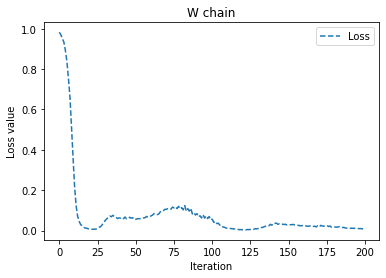

In [41]:
from matplotlib import pyplot as plt
# plt.plot(fidelities, label='Fidelity', linestyle = '-')
# plt.plot(traces, label='Trace', linestyle = '-.')
plt.plot(loss_values, label='Loss', linestyle = '--')
plt.title('W chain')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss value")
plt.show() 

In [25]:
qc = qiskit.QuantumCircuit(2,2)
qc_copy = qc.copy()
qc_copy.cry(1, 0 , 1)
print(qiskit.quantum_info.Statevector.from_instruction(qc_copy).data)
observers = qtm.fubini_study.create_observers(qc_copy)

print(qtm.fubini_study.calculate_g(qc, observers))
qc.draw()

[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
[[0.25+0.j]]


q_0: 
     
q_1: 
     
c: 2/

### 2. W alternating

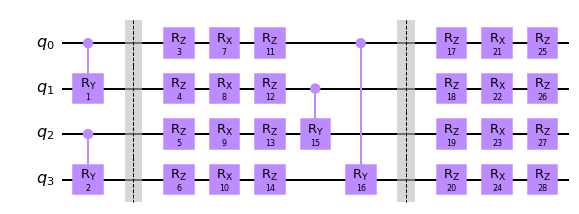

In [10]:
num_qubits = 4
num_layers = 2
n_alternating = 0
for i in range(0, num_layers):
    n_alternating += qtm.nqubit.calculate_n_walternating(i, num_qubits)
thetas = np.ones(n_alternating + 3 * num_layers * num_qubits)

for i in range(0, len(thetas)):
    thetas[i] += i

psi = 2 * np.random.rand(2**num_qubits) - 1
psi = psi / np.linalg.norm(psi)
encoder = qtm.encoding.Encoding(psi, 'amplitude_encoding')
qc = qiskit.QuantumCircuit(num_qubits)
qc = qtm.nqubit.create_Walternating_layerd_state(qc,
                                                 thetas,
                                                 num_layers=num_layers)
qc.draw('mpl')


In [11]:
num_qubits = 4
num_layers = 2
n_alternating = 0
for i in range(0, num_layers):
    n_alternating += qtm.nqubit.calculate_n_walternating(i, num_qubits)
thetas = np.ones(n_alternating + 3 * num_layers * num_qubits)

for i in range(0, len(thetas)):
    thetas[i] += i

psi = 2 * np.random.rand(2**num_qubits) - 1
psi = psi / np.linalg.norm(psi)
encoder = qtm.encoding.Encoding(psi, 'amplitude_encoding')


loss_values = []
thetass = []
for i in range(0, 100):
    if i % 20 == 0:
        print('W_alternating: ', i)
    qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    G = qtm.fubini_study.calculate_Walternating_state(qc, thetas, num_layers)
    qc = encoder.qcircuit
    grad_loss = qtm.base.grad_loss(
        qc, 
        qtm.nqubit.create_Walternatingchecker_haar,
        thetas, r = 1/2, s = np.pi/2, num_layers = num_layers)
    thetas = np.real(thetas - qtm.constant.learning_rate*(np.linalg.pinv(G) @ grad_loss)) 
    thetass.append(thetas.copy())
    qc_copy = qtm.nqubit.create_Walternatingchecker_haar(qc.copy(), thetas, num_layers)  
    loss = qtm.base.loss_basis(qtm.base.measure(qc_copy, list(range(qc_copy.num_qubits))))
    loss_values.append(loss)


W_alternating:  0
W_alternating:  20
W_alternating:  40
W_alternating:  60
W_alternating:  80


In [27]:
traces = []
fidelities = []

for thetas in thetass:
    # Get |psi> = U_gen|000...>
    qc1 = encoder.qcircuit
    psi = qiskit.quantum_info.Statevector.from_instruction(qc1)
    # Get |psi~> = U_target|000...>
    qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    qc = qtm.nqubit.create_Walternating_layerd_state(qc, thetas, num_layers = num_layers).inverse()
    psi_hat = qiskit.quantum_info.Statevector.from_instruction(qc)
    # Calculate the metrics
    trace, fidelity = qtm.base.get_metrics(psi, psi_hat)
    traces.append(trace)
    fidelities.append(fidelity)
print('Writting ... ' + str(num_qubits))

np.savetxt("../../experiments/tomography_walternating_" + str(num_layers) + '/' + str(num_qubits) + "/loss_values_qng.csv", loss_values, delimiter=",")
np.savetxt("../../experiments/tomography_walternating_" + str(num_layers) + '/' + str(num_qubits) + "/thetass_qng.csv", thetass, delimiter=",")
np.savetxt("../../experiments/tomography_walternating_" + str(num_layers) + '/' + str(num_qubits) + "/traces_qng.csv", traces, delimiter=",")
np.savetxt("../../experiments/tomography_walternating_" + str(num_layers) + '/' + str(num_qubits) + "/fidelities_qng.csv", fidelities, delimiter=",")

Writting ... 3


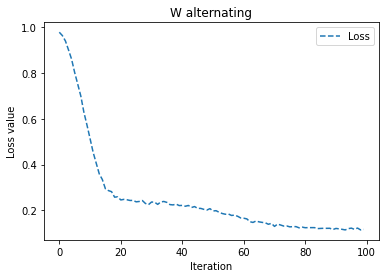

In [12]:
from matplotlib import pyplot as plt
# plt.plot(fidelities, label='Fidelity', linestyle = '-')
# plt.plot(traces, label='Trace', linestyle = '-.')
plt.plot(loss_values, label='Loss', linestyle = '--')
plt.title('W alternating')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss value")
plt.show() 


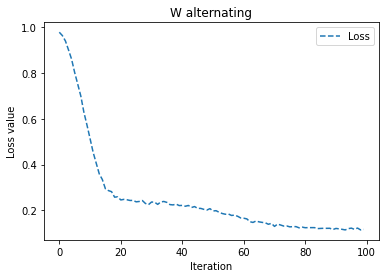

In [13]:
from matplotlib import pyplot as plt
# plt.plot(fidelities, label='Fidelity', linestyle = '-')
# plt.plot(traces, label='Trace', linestyle = '-.')
plt.plot(loss_values, label='Loss', linestyle = '--')
plt.title('W alternating')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss value")
plt.show() 


### 3. W all to all

3


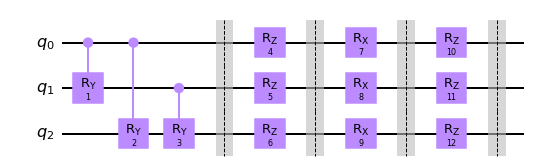

In [3]:
num_qubits = 3
num_layers = 1
n_walltoall = qtm.nqubit.calculate_n_walltoall(num_qubits)
print(n_walltoall)
thetas = np.ones(num_layers * 3 * num_qubits + num_layers * n_walltoall)
for i in range(0, len(thetas)):
    thetas[i] += i
psi = 2 * np.random.rand(2**num_qubits) - 1
psi = psi / np.linalg.norm(psi)
encoder = qtm.encoding.Encoding(psi, 'amplitude_encoding')
qc = qiskit.QuantumCircuit(num_qubits)
qc = qtm.nqubit.create_Walltoall_layerd_state(qc,
                                              thetas,
                                              num_layers=num_layers)
qc.draw('mpl')

In [1]:
import qiskit
import numpy as np
import sys
sys.path.insert(1, '../')
import qtm.base, qtm.constant, qtm.nqubit, qtm.fubini_study, qtm.encoding
import importlib
importlib.reload(qtm.base)
importlib.reload(qtm.constant)
importlib.reload(qtm.onequbit)
importlib.reload(qtm.nqubit)
importlib.reload(qtm.fubini_study)

<module 'qtm.fubini_study' from '..\\qtm\\fubini_study.py'>

In [14]:
num_qubits = 4
num_layers = 2
n_walltoall = qtm.nqubit.calculate_n_walltoall(num_qubits)
thetas = np.ones(num_layers* 3 * num_qubits + num_layers*n_walltoall)
for i in range(0, len(thetas)):
    thetas[i] += i
psi = 2*np.random.rand(2**num_qubits)-1
psi = psi / np.linalg.norm(psi)
encoder = qtm.encoding.Encoding(psi, 'amplitude_encoding')


loss_values = []
thetass = []
for i in range(0, 200):
    if i % 20 == 0:
        print('W_chain: ', i)
    qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    G = qtm.fubini_study.calculate_Walltoall_state(qc, thetas, num_layers)
    qc = encoder.qcircuit
    grad_loss = qtm.base.grad_loss(
        qc, 
        qtm.nqubit.create_Walltoallchecker_haar,
        thetas, r = 1/2, s = np.pi/2, num_layers = num_layers)
    thetas -= qtm.constant.learning_rate*(grad_loss) 
    thetass.append(thetas.copy())
    qc_copy = qtm.nqubit.create_Walltoallchecker_haar(qc.copy(), thetas, num_layers)  
    loss = qtm.base.loss_basis(qtm.base.measure(qc_copy, list(range(qc_copy.num_qubits))))
    loss_values.append(loss)


W_chain:  0
W_chain:  20
W_chain:  40
W_chain:  60
W_chain:  80
W_chain:  100
W_chain:  120
W_chain:  140
W_chain:  160
W_chain:  180


In [111]:
traces = []
fidelities = []

for thetas in thetass:
    # Get |psi> = U_gen|000...>
    qc1 = encoder.qcircuit
    psi = qiskit.quantum_info.Statevector.from_instruction(qc1)
    # Get |psi~> = U_target|000...>
    qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    qc = qtm.nqubit.create_Walltoall_layerd_state(qc, thetas, num_layers = num_layers).inverse()
    psi_hat = qiskit.quantum_info.Statevector.from_instruction(qc)
    # Calculate the metrics
    trace, fidelity = qtm.base.get_metrics(psi, psi_hat)
    traces.append(trace)
    fidelities.append(fidelity)
print('Writting ... ' + str(num_qubits))


np.savetxt("../../experiments/tomography_walltoall_" + str(num_layers) + '/' + str(num_qubits) + "/loss_values_qng.csv", loss_values, delimiter=",")
np.savetxt("../../experiments/tomography_walltoall_" + str(num_layers) + '/' + str(num_qubits) + "/thetass_qng.csv", thetass, delimiter=",")
np.savetxt("../../experiments/tomography_walltoall_" + str(num_layers) + '/' + str(num_qubits) + "/traces_qng.csv", traces, delimiter=",")
np.savetxt("../../experiments/tomography_walltoall_" + str(num_layers) + '/' + str(num_qubits) + "/fidelities_qng.csv", fidelities, delimiter=",")

Writting ... 3


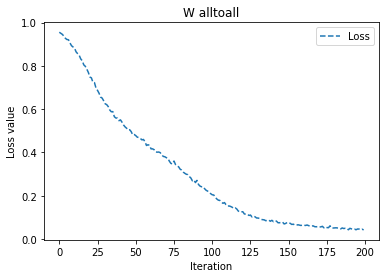

In [15]:
from matplotlib import pyplot as plt
# plt.plot(fidelities, label='Fidelity', linestyle = '-')
# plt.plot(traces, label='Trace', linestyle = '-.')
plt.plot(loss_values, label='Loss', linestyle = '--')
plt.title('W alltoall')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss value")
plt.show() 


6


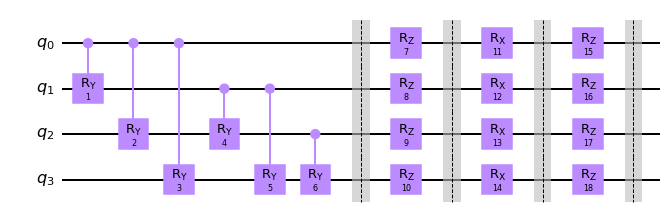

In [49]:
num_qubits = 4
num_layers = 1
n_walltoall = qtm.nqubit.calculate_n_walltoall(num_qubits)
print(n_walltoall)
thetas = np.ones(num_layers* 3 * num_qubits + num_layers*n_walltoall)
for i in range(0, len(thetas)):
    thetas[i] += i
psi = 2*np.random.rand(2**num_qubits)-1
psi = psi / np.linalg.norm(psi)
encoder = qtm.encoding.Encoding(psi, 'amplitude_encoding')
qc = qiskit.QuantumCircuit(num_qubits)
qc = qtm.nqubit.create_Walltoall_layerd_state(qc, thetas, num_layers=num_layers)
qc.draw('mpl')

